In [ ]:
# imports and connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

Mounted at /content/gdrive


In [ ]:
# Read the CSV files copied into google drive above into pandas DataFrames
# Add some columns logging data which should normalize the data a bit
test = pd.read_csv('/content/gdrive/MyDrive/CS 74/test.csv')
test['minimum_nights_log'] = np.log(test.minimum_nights+1)
test['number_of_reviews_log'] = np.log(test.number_of_reviews+1)
train = pd.read_csv('/content/gdrive/MyDrive/CS 74/train.csv')
train['price_log'] = np.log(train.price+1)
train['number_of_reviews_log'] = np.log(train.number_of_reviews+1)
train['minimum_nights_log'] = np.log(train.minimum_nights+1)


In [ ]:
# Displaying basic info about data
print(train.shape)
print(test.shape)
print(train.columns)
print(test.columns)

# Displaying first few rows of training set
train.head(15)

(16221, 25)
(5407, 23)
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license', 'price', 'price_log',
       'number_of_reviews_log', 'minimum_nights_log', 'price_near',
       'price_near_log', 'price_room', 'price_room_log'],
      dtype='object')
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license', 'minimum_nights_log',
       'number_of_reviews_log', 'price_near', 'price_near_log', 'price_room',
       'price_room_log'],
      dtype='object')


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,...,number_of_reviews_ltm,license,price,price_log,number_of_reviews_log,minimum_nights_log,price_near,price_near_log,price_room,price_room_log
0,a922764,Top Floor 2bd Luxury Brownstone Apt,1204785,Lorrie,Brooklyn,Fort Greene,40.68601,-73.97515,Entire home/apt,30,...,1,NaN,199,5.298317,5.627621,3.433987,198.520000,5.290890,204.221060,5.319203
1,a16365302,Bond Street 2 bedroom 2 bath great NOHO location,24074171,Donna,Manhattan,NoHo,40.72693,-73.99322,Entire home/apt,3,...,0,NaN,432,6.070738,3.637586,1.386294,203.345045,5.314904,204.221060,5.319203
2,a2432622,Your new happy place in Greenpoint/Williamsburg,377287,Marianne,Brooklyn,Greenpoint,40.72358,-73.95426,Entire home/apt,2,...,3,NaN,400,5.993961,3.258097,1.098612,185.466926,5.222877,204.221060,5.319203
3,a2525956,Beautiful 1 Bdr in the heart of NYC,7365834,Alex,Manhattan,Theater District,40.76038,-73.98196,Entire home/apt,30,...,0,NaN,129,4.867534,2.833213,3.433987,217.294872,5.381255,204.221060,5.319203
4,a34340299,Spacious 1 bed apartment with private terrace,41213523,Mathieu,Manhattan,East Village,40.72899,-73.98091,Entire home/apt,30,...,0,NaN,250,5.525453,2.079442,3.433987,195.832930,5.277262,204.221060,5.319203
5,a9918963,Brooklyn Apt with Patio in Heart of Fort Greene,50994782,Clay,Brooklyn,Fort Greene,40.68851,-73.97124,Entire home/apt,2,...,8,NaN,175,5.170484,3.465736,1.098612,198.520000,5.290890,204.221060,5.319203
6,a682684527659690406,Green Olives Condominiums 1,60847286,Mohammad,Queens,Woodside,40.74223,-73.90580,Private room,2,...,9,NaN,125,4.836282,2.302585,1.098612,95.710000,4.561323,96.886403,4.573539
7,a54364623,Romantic and sunny 2-bedrooms rental unit Broo...,13187650,L'Equipe,Brooklyn,Bedford-Stuyvesant,40.68930,-73.95454,Entire home/apt,1,...,38,NaN,288,5.666427,3.713572,0.693147,141.968847,4.955608,204.221060,5.319203
8,a726667728496451227,Charming 2 bedroom in a quiet tree lined street,188737645,John,Bronx,Pelham Gardens,40.86457,-73.84112,Entire home/apt,3,...,10,NaN,121,4.804021,2.397895,1.386294,103.235537,4.637013,204.221060,5.319203
9,a824421,Central Williamsburg Fab Large Room,4328005,Dina,Brooklyn,Williamsburg,40.71803,-73.96211,Private room,30,...,0,NaN,70,4.262680,2.079442,3.433987,179.550314,5.190455,96.886403,4.573539


The dataset we are looking at is data collected from Airbnb listings in New York City from 2008 to 2019. Several relevant factors include:

  Location (neighborhood, latitude, longitude)

  Housing Information (type of room)

  Booking/Housing Information (type of room, minimum # of nights, # of days in the year the listing is available, license)

  Reviews (total # of reviews, date of last review, average # of reviews per month)

  Host Information (host name, host id, how many listings the host has)


The target variable we are looking at is price. In the training dataset, we build a regression model that uses all the features we deem important as well as some columns we create, using the target price that is known to us in the training dataset. Then, we can apply our regression model to the test data where we do not know the price.

Looking at above, we can see the first 5 data points in the training data set. Looking at the actual data in them, we can see how the features for each airnbnd come together to determine a price. For example, the airbnb with id "a922764" is a floor of a brownstonein Fort Greene, Brooklyn. Without going into every single feature, the airbnb has a significant number of review (277), must be booked for at least a month, and is priced by the host Lorrie at $199$. Another airbnd described above has an id "a16365302." This airbnb is a 2 bedroom/bath apartment in NoHo, Manhattan. It has a 37 total reviews, must be booked for at least 3 nights, and is priced at $432$. Finally, a third airbnb described above has an id "a2432622". It is an apartment in Greenpoint, Brooklyn, must be booked for at least 2 night, has 25 total reviews, and is listed at a price of $400$.

In [ ]:
# create new column that should be helpful for giving numerical value to a 'neighbourhood'
# if a neighbourhood appears at least 46 times, then the new columne price_near will be the average
# price of rentals in that neighbourhood, otherwise it will just be the average price of rentals
# in its borough

# adding column in train dataframe
# Calculate mean prices by "neighbourhood"
neighbourhood_mean_prices = train.groupby('neighbourhood')['price'].mean().to_dict()
# Calculate mean prices by "neighbourhood_group"
neighbourhood_group_mean_prices = train.groupby('neighbourhood_group')['price'].mean().to_dict()
# Calculate the counts of each "neighbourhood"
neighbourhood_counts = train['neighbourhood'].value_counts()
# Create the "price_near" column based on the specified conditions of neighbourhood appearing at 46 times
train['price_near'] = train.apply(lambda row: neighbourhood_mean_prices[row['neighbourhood']] if neighbourhood_counts[row['neighbourhood']] > 45
                                   else neighbourhood_group_mean_prices[row['neighbourhood_group']], axis=1)
# log the column we just made to hopefully normalize the data
train['price_near_log'] = np.log(train['price_near'])


# add column in test datafram
# Use the dictionaries to map mean prices based on "neighbourhood"
test['price_near'] = test['neighbourhood'].apply(lambda x: neighbourhood_mean_prices[x] if x in neighbourhood_counts and neighbourhood_counts[x] > 45 else None)
# Fill missing values in "price_near" with the mean prices based on "neighbourhood_group"
test['price_near'].fillna(test['neighbourhood_group'].map(neighbourhood_group_mean_prices), inplace=True)
# log the new column to hopefully normalize the data
test['price_near_log'] = np.log(test['price_near'])

# calculate mean prices by room_type
room_type_mean_prices = train.groupby('room_type')['price'].mean().to_dict()
train['price_room']= train['room_type'].apply(lambda x: room_type_mean_prices[x])
train['price_room_log']= np.log(train['price_room'])
test['price_room']= test['room_type'].apply(lambda x: room_type_mean_prices[x])
test['price_room_log']= np.log(test['price_room'])

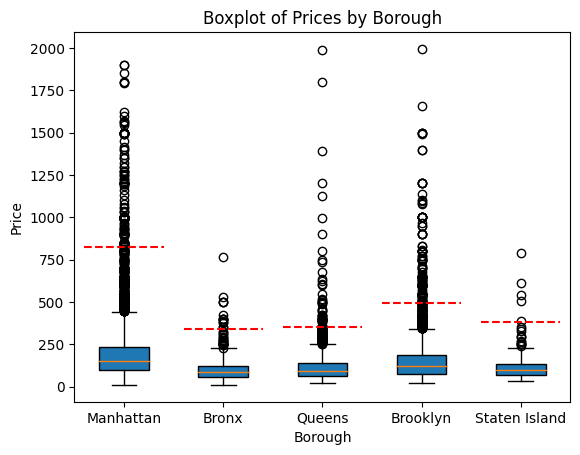

Number of airbnbs in Manhattan: 5863. The 98th percentile is at 822.6000000000022
Number of airbnbs in Bronx: 726. The 98th percentile is at 337.5
Number of airbnbs in Queens: 2877. The 98th percentile is at 350.0
Number of airbnbs in Brooklyn: 6553. The 98th percentile is at 494.8000000000002
Number of airbnbs in Staten Island: 202. The 98th percentile is at 384.2999999999996


In [ ]:
# code to visualize the prices for each borough in boxplots


Boroughs = ['Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island']
data_by_borough = [train[train.neighbourhood_group == borough].price for borough in Boroughs]

# create graph
fig, ax = plt.subplots()
positions = np.arange(len(Boroughs)) + 1
bplot = ax.boxplot(data_by_borough, vert=True, patch_artist=True, positions=positions)

# Calculate the 98th percentile for each data set
percentiles_98 = [np.percentile(data, 98) for data in data_by_borough]

# Add a horizontal line at the 98th percentile for each box plot
for i in range(len(positions)):
    ax.hlines(percentiles_98[i], positions[i] - 0.4, positions[i] + 0.4, colors='red', linestyles='dashed')

ax.set_xticks(positions)
ax.set_xticklabels(Boroughs)
ax.set_xlabel('Borough')
ax.set_ylabel('Price')
ax.set_title('Boxplot of Prices by Borough')

# Show the plot
plt.show()

# print out info
for i in range(len(Boroughs)):
  number=train[train.neighbourhood_group == Boroughs[i]].shape[0]
  print(f'Number of airbnbs in {Boroughs[i]}: {number}. The 98th percentile is at {percentiles_98[i]}')

# the box plots below are used to see which airbnbs have prices that are outliers per borough

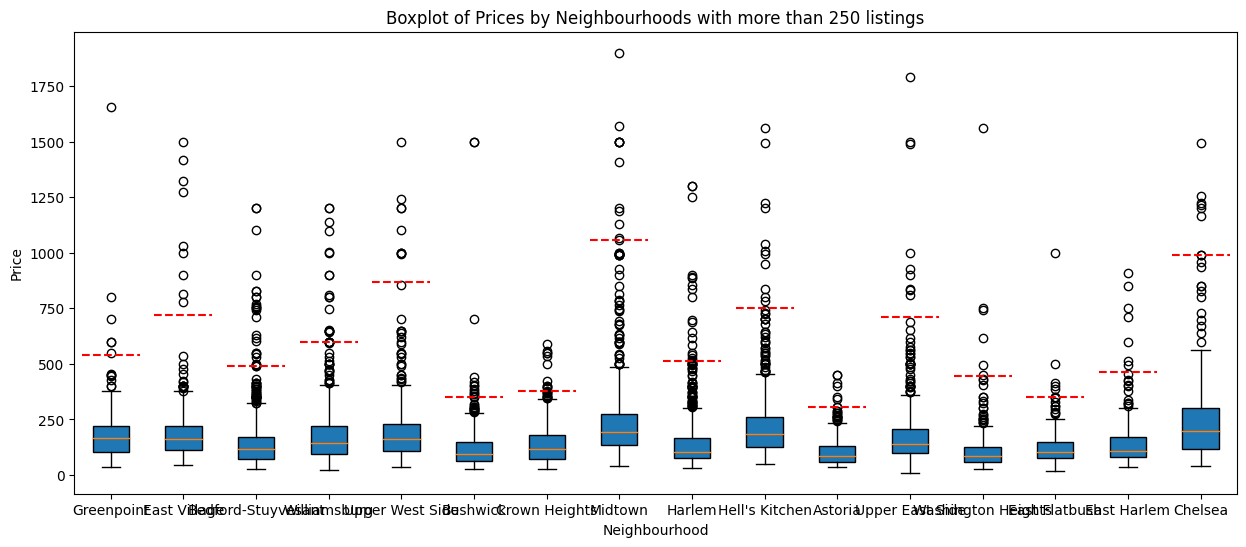

Number of airbnbs in Greenpoint: 257. The 98th percentile is at 538.5999999999996
Number of airbnbs in East Village: 413. The 98th percentile is at 719.1599999999978
Number of airbnbs in Bedford-Stuyvesant: 1284. The 98th percentile is at 489.0
Number of airbnbs in Williamsburg: 954. The 98th percentile is at 600.0
Number of airbnbs in Upper West Side: 447. The 98th percentile is at 868.0399999999978
Number of airbnbs in Bushwick: 646. The 98th percentile is at 350.20000000000005
Number of airbnbs in Crown Heights: 559. The 98th percentile is at 375.84000000000003
Number of airbnbs in Midtown: 542. The 98th percentile is at 1058.2599999999998
Number of airbnbs in Harlem: 894. The 98th percentile is at 511.1199999999999
Number of airbnbs in Hell's Kitchen: 540. The 98th percentile is at 752.2400000000011
Number of airbnbs in Astoria: 334. The 98th percentile is at 305.67999999999995
Number of airbnbs in Upper East Side: 442. The 98th percentile is at 711.7800000000009
Number of airbnbs 

In [ ]:
# visualize the prices for each neighbourhood with boxplots
# since there are so many neighbourhoods, we only do this with neighbourhoods that
# appear more than 250 times, but it should be clear just from that neighbourhoods
# within the same borough can have drastically different price boxplots

# create array
sufficient_neighbourhoods = []
neighbourhoods = train.neighbourhood.unique()
for neighbourhood in neighbourhoods:
  if train[train.neighbourhood == neighbourhood].shape[0] > 250:
    sufficient_neighbourhoods.append(neighbourhood)

# gather data of prices for all the neighbourhoods in sufficient_neighbourhoods
data_by_neighbourhood = [train[train.neighbourhood == neighbourhood].price for neighbourhood in sufficient_neighbourhoods]

# create graphs
fig, ax = plt.subplots(figsize=(15, 6))
positions = np.arange(len(sufficient_neighbourhoods)) + 1
bplot = ax.boxplot(data_by_neighbourhood, vert=True, patch_artist=True, positions=positions)
# Calculate the 98th percentile for each data set
percentiles_98 = [np.percentile(data, 98) for data in data_by_neighbourhood]
# Add a horizontal line at the 98th percentile for each box plot
for i in range(len(positions)):
  ax.hlines(percentiles_98[i], positions[i] - 0.4, positions[i] + 0.4, colors='red', linestyles='dashed')

ax.set_xticks(positions)
ax.set_xticklabels(sufficient_neighbourhoods)
ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Price')
ax.set_title('Boxplot of Prices by Neighbourhoods with more than 250 listings')
plt.show()

# print out info
for i in range(len(sufficient_neighbourhoods)):
  number = train[train.neighbourhood == sufficient_neighbourhoods[i]].shape[0]
  print(f'Number of airbnbs in {sufficient_neighbourhoods[i]}: {number}. The 98th percentile is at {percentiles_98[i]}')

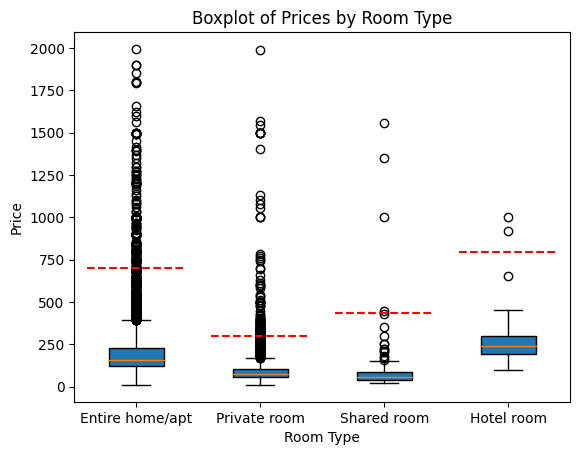

Number of airbnbs of of room type Entire home/apt: 9658
Number of airbnbs of of room type Private room: 6303
Number of airbnbs of of room type Shared room: 186
Number of airbnbs of of room type Hotel room: 74


In [ ]:
# graph box plots of prices per type of room
room_types = train.room_type.unique()
data_by_room_type = [train[train.room_type == room].price for room in room_types]

fig, ax = plt.subplots()

# Calculate positions for the boxplots
positions = np.arange(len(room_types)) + 1

# Create boxplots
bplot = ax.boxplot(data_by_room_type, vert=True, patch_artist=True, positions=positions)
ax.set_xticks(positions)
ax.set_xticklabels(room_types)
ax.set_xlabel('Room Type')
ax.set_ylabel('Price')
ax.set_title('Boxplot of Prices by Room Type')

percentiles_98 = [np.percentile(data, 98) for data in data_by_room_type]
# Add a horizontal line at the 98th percentile for each box plot
for i in range(len(positions)):
  ax.hlines(percentiles_98[i], positions[i] - 0.4, positions[i] + 0.4, colors='red', linestyles='dashed')

plt.show()

# print info
for room_type in room_types:
  number=train[train.room_type== room_type].shape[0]
  print(f'Number of airbnbs of of room type {room_type}: {number}')



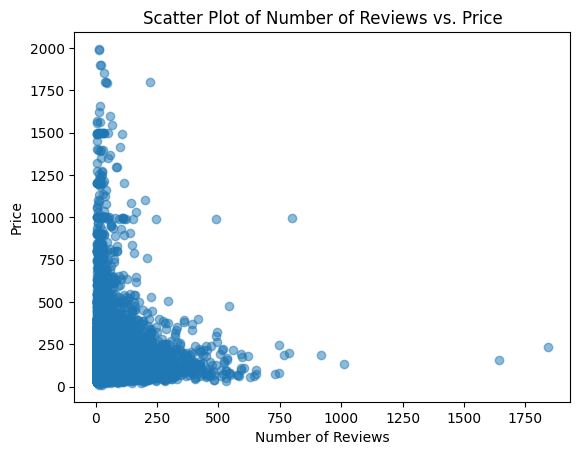

In [ ]:
# scatter plot of number of reviews vs price


# make graph
plt.scatter(train.number_of_reviews, train.price, alpha=0.5)

# Add labels and title
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Scatter Plot of Number of Reviews vs. Price')

# Display the plot
plt.show()

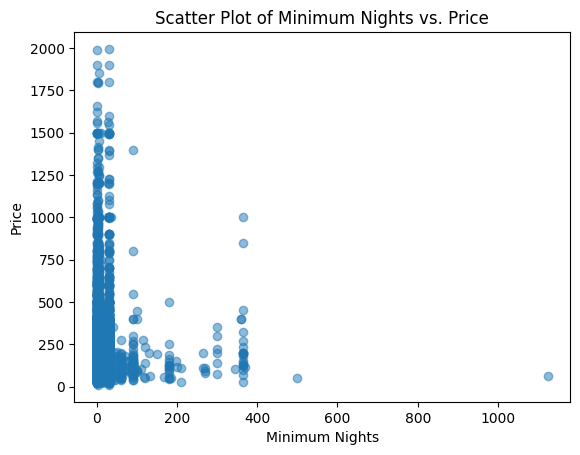

In [ ]:
# Scatter plot of minimum nights vs price

plt.scatter(train.minimum_nights, train.price, alpha=0.5)

# Add labels and title
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.title('Scatter Plot of Minimum Nights vs. Price')

# Display the plot
plt.show()

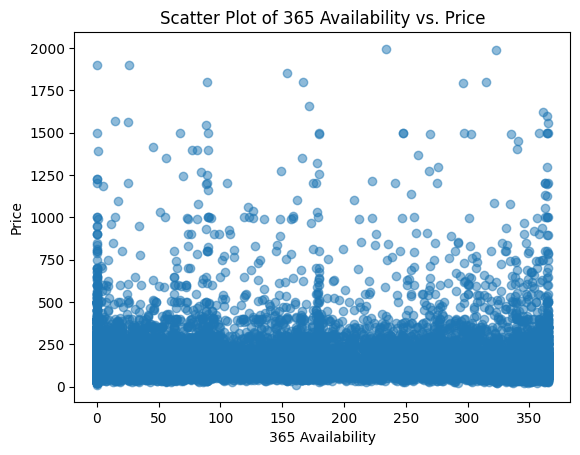

In [ ]:
# Scatter plot of availability_365 vs price
plt.scatter(train.availability_365, train.price, alpha=0.5)

# Add labels and title
plt.xlabel('365 Availability')
plt.ylabel('Price')
plt.title('Scatter Plot of 365 Availability vs. Price')

# Display the plot
plt.show()


In [ ]:
# Copy the 'train' DataFrame into 'cat_train'
cat_train = train.copy()
# Convert categorical columns to numerical codes
cat_train['neighbourhood_group'] = cat_train['neighbourhood_group'].astype('category').cat.codes
cat_train['neighbourhood'] = cat_train['neighbourhood'].astype('category').cat.codes
cat_train['room_type'] = cat_train['room_type'].astype('category').cat.codes

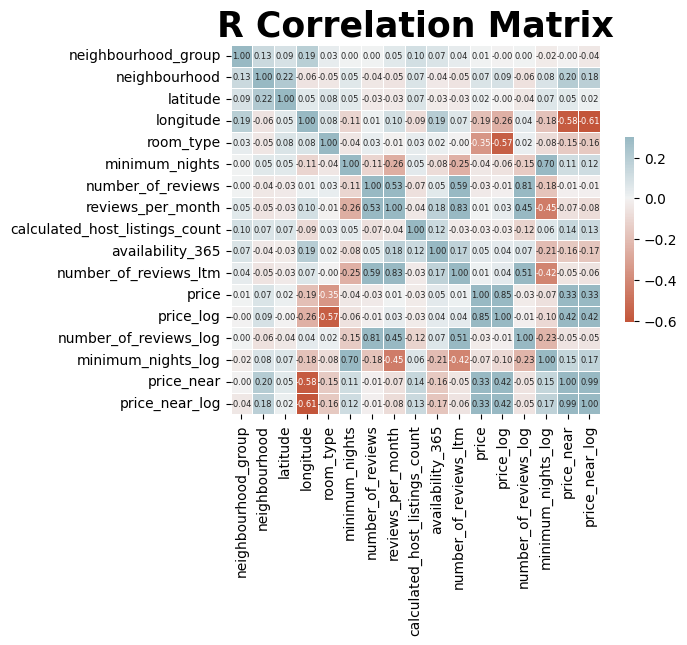

In [ ]:
# create R correlation matrix between every variable
# for the string variables, (neighbourhood_group, neighbourhood, and room_type)
# we just used above code to make the columns numerics

corrdata = cat_train.drop(columns=['name', 'id', 'host_id', 'host_name', 'last_review', 'license'])

# Calculate R-squared (squared correlation)
corr = corrdata.corr(method='pearson', numeric_only=True)

# Set up the color palette
palette = sns.diverging_palette(20, 220, n=256)

# Plot the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size":6})


# Set the title
plt.title("R Correlation Matrix", size=25, weight='bold')

# Show the plot
plt.show()

In [ ]:
# Example of using training validation set to compare among different models, which
# here decided that linear regression was the best choice
features = ["room_type", "number_of_reviews_log", "neighbourhood_group", "minimum_nights_log", "longitude", "availability_365", "calculated_host_listings_count", "latitude", "price_near_log", "price_room_log"]
X = train[features].copy()
y = train["price"].copy()

# Identify non-float features for encoding
non_float_features = ["neighbourhood_group", "room_type"]
encoder = OrdinalEncoder()
X[non_float_features] = encoder.fit_transform(X[non_float_features].values)

# split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


k_folds = 5  # Choose an appropriate number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Models to test
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Linear': LinearRegression(),
    'ElasticNet': ElasticNet()
}


# Hyperparameters to tune for each model, should probably test more options for regularization parameters
param_grid = {
    'Ridge': {'ridge__alpha': np.arange(.1, 1, 0.2)},
    'Lasso': {'lasso__alpha': np.arange(.1, 1, 0.2)},
    'Linear': {},
    'ElasticNet': {'elasticnet__alpha': np.arange(.1, 1, 0.2), 'elasticnet__l1_ratio': np.arange(.1, 1, 0.2)}
}

# Degrees of polynomial transformation to try
degrees = [1,2]

best_overall_model = None
best_overall_mse = float('inf')

for degree_num in degrees:
  # Dictionary to store the best models for each technique
  best_models = {}

  # Perform K-fold cross-validation for each model
  for model_name, model in models.items():
      pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree_num), model)
      grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=k_folds, scoring='neg_mean_squared_error', verbose=0)
      grid_search.fit(X_train, y_train)
      best_models[model_name] = grid_search.best_estimator_

  for model_name, best_model in best_models.items():
      best_model.fit(X_train, y_train)

  best_model_name = min(best_models, key=lambda k: mean_squared_error(y_val, best_models[k].predict(X_val)))
  print({best_model_name})
  # Use the best model for predictions on the test set
  best_model = best_models[best_model_name]
  y_pred_val = best_model.predict(X_val)
  mse_val = mean_squared_error(y_val, y_pred_val)
  if mse_val < best_overall_mse:
      best_overall_mse = mse_val
      best_overall_model = best_model

test_features = test[features].copy()
encoder = OrdinalEncoder()
test_features[non_float_features] = encoder.fit_transform(test_features[non_float_features].values)
y_pred = best_overall_model.predict(test_features)
# Create a submission DataFrame
submission_data = {'id': test['id'], 'price': y_pred}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("my_submission1.csv", index = False)

{'ElasticNet'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.684e+04, tolerance: 2.665e+04
  model = cd_fast.enet_coordinate_descent(


{'Linear'}


In [ ]:
# Performance: 111
# Load your dataset and preprocess it
filtered = train
# Features and target
# features = ["room_type", "number_of_reviews_log", "neighbourhood_group", "minimum_nights_log", "longitude", "availability_365", "calculated_host_listings_count", "latitude", "price_near"]

features = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
            'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
            'calculated_host_listings_count', 'availability_365',
            'number_of_reviews_ltm', 'number_of_reviews_log', 'minimum_nights_log',
            'price_near', 'price_near_log', 'price_room', 'price_room_log']
X_train = filtered[features].copy()
y_train = filtered["price"].copy()

X_train['neighbourhood_group'] = X_train['neighbourhood_group'].astype("category").cat.codes
X_train['room_type'] = X_train['room_type'].astype("category").cat.codes
X_train['neighbourhood'] = X_train['neighbourhood'].astype("category").cat.codes


# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Test Features (assuming you have loaded and preprocessed your test dataset)
test_features = test[features].copy()
test_features['neighbourhood_group'] = test_features['neighbourhood_group'].astype("category").cat.codes
test_features['room_type'] = test_features['room_type'].astype("category").cat.codes
test_features['neighbourhood'] = test_features['neighbourhood'].astype("category").cat.codes

scaler = StandardScaler()
test_features = scaler.fit_transform(test_features)

# Split the dataset into a training set and a validation set for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [500],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [4]
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best hyperparameters (All&Filtered:{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300})
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)
best_rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = best_rf_model.predict(X_val)

# Calculate the RMSE (Root Mean Squared Error) on the validation set
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Validation RMSE:", rmse)

# Make predictions on the test set
test_predictions = best_rf_model.predict(test_features)

submission_data = {'id': test['id'], 'price': test_predictions}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("/content/gdrive/MyDrive/CS 74/proj1subnorm.csv", index=False)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Validation RMSE: 117.66065956362482


In [ ]:
# Random Forest Regressor w/o Training/Validation Split
# Load your dataset and preprocess it
filtered = train
# Features and target
# features = ["room_type", "number_of_reviews_log", "neighbourhood_group", "minimum_nights_log", "longitude", "availability_365", "calculated_host_listings_count", "latitude", "price_near"]

features = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
            'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
            'calculated_host_listings_count', 'availability_365',
            'number_of_reviews_ltm', 'number_of_reviews_log', 'minimum_nights_log',
            'price_near', 'price_near_log', 'price_room', 'price_room_log']
X_train = filtered[features].copy()
y_train = filtered["price"].copy()

X_train['neighbourhood_group'] = X_train['neighbourhood_group'].astype("category").cat.codes
X_train['room_type'] = X_train['room_type'].astype("category").cat.codes
X_train['neighbourhood'] = X_train['neighbourhood'].astype("category").cat.codes


# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Test Features (assuming you have loaded and preprocessed your test dataset)
test_features = test[features].copy()
test_features['neighbourhood_group'] = test_features['neighbourhood_group'].astype("category").cat.codes
test_features['room_type'] = test_features['room_type'].astype("category").cat.codes
test_features['neighbourhood'] = test_features['neighbourhood'].astype("category").cat.codes

scaler = StandardScaler()
test_features = scaler.fit_transform(test_features)

# Split the dataset into a training set and a validation set for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=500, max_depth=30, min_samples_split=2, min_samples_leaf=4)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = rf_model.predict(test_features)

submission_data = {'id': test['id'], 'price': test_predictions}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("/content/gdrive/MyDrive/CS 74/proj1subnorm.csv", index=False)
